# 🔐 Unsupervised Network Intrusion Detection

## Overview

This notebook implements an unsupervised machine learning approach to detect anomalous network traffic using K-Means clustering on the NSL-KDD dataset. The model is trained without using attack labels, learning traffic behavior patterns directly from the data. Ground-truth labels are used only for evaluation to assess how well the discovered clusters separate normal and malicious activity.

## Workflow

The notebook demonstrates a complete practical workflow including:

- Data preprocessing and feature encoding
- K-Means clustering for pattern discovery
- Performance analysis and evaluation metrics

## Dataset

The **NSL-KDD dataset** is an improved version of the KDD Cup 1999 dataset, containing network connection records with features describing connection characteristics and labeled attack types.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

####Load Data

In [4]:
import kagglehub

path = kagglehub.dataset_download("hassan06/nslkdd")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'nslkdd' dataset.
Path to dataset files: /kaggle/input/nslkdd


In [5]:
import os

os.listdir(path)

['KDDTest+.arff',
 'KDDTest-21.arff',
 'KDDTest1.jpg',
 'KDDTrain+.txt',
 'KDDTrain+_20Percent.txt',
 'KDDTest-21.txt',
 'KDDTest+.txt',
 'KDDTrain+.arff',
 'index.html',
 'nsl-kdd',
 'KDDTrain+_20Percent.arff',
 'KDDTrain1.jpg']

In [9]:
training_dataset = os.path.join(path, "KDDTrain+.txt")

train_df = pd.read_csv(training_dataset, header=None, sep=",")

In [10]:
display(train_df.head(10))

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21
5,0,tcp,private,REJ,0,0,0,0,0,0,...,0.07,0.07,0.00,0.00,0.00,0.00,1.00,1.00,neptune,21
6,0,tcp,private,S0,0,0,0,0,0,0,...,0.04,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,21
7,0,tcp,private,S0,0,0,0,0,0,0,...,0.06,0.07,0.00,0.00,1.00,1.00,0.00,0.00,neptune,21
8,0,tcp,remote_job,S0,0,0,0,0,0,0,...,0.09,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,21
9,0,tcp,private,S0,0,0,0,0,0,0,...,0.05,0.06,0.00,0.00,1.00,1.00,0.00,0.00,neptune,21


In [11]:
print("Training Dataset shape: ", train_df.shape)
print("Training samples: ", train_df.shape[0])
print("Training features: ", train_df.shape[1])

Training Dataset shape:  (125973, 43)
Training samples:  125973
Training features:  43


In [12]:
testing_dataset = os.path.join(path, "KDDTest+.txt")

test_df = pd.read_csv(testing_dataset, header=None, sep=",")

In [13]:
display(test_df.head(10))

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
0,0,tcp,private,REJ,0,0,0,0,0,0,...,0.04,0.06,0.00,0.00,0.00,0.00,1.00,1.00,neptune,21
1,0,tcp,private,REJ,0,0,0,0,0,0,...,0.00,0.06,0.00,0.00,0.00,0.00,1.00,1.00,neptune,21
2,2,tcp,ftp_data,SF,12983,0,0,0,0,0,...,0.61,0.04,0.61,0.02,0.00,0.00,0.00,0.00,normal,21
3,0,icmp,eco_i,SF,20,0,0,0,0,0,...,1.00,0.00,1.00,0.28,0.00,0.00,0.00,0.00,saint,15
4,1,tcp,telnet,RSTO,0,15,0,0,0,0,...,0.31,0.17,0.03,0.02,0.00,0.00,0.83,0.71,mscan,11
5,0,tcp,http,SF,267,14515,0,0,0,0,...,1.00,0.00,0.01,0.03,0.01,0.00,0.00,0.00,normal,21
6,0,tcp,smtp,SF,1022,387,0,0,0,0,...,0.11,0.72,0.00,0.00,0.00,0.00,0.72,0.04,normal,21
7,0,tcp,telnet,SF,129,174,0,0,0,0,...,1.00,0.00,0.00,0.00,0.01,0.01,0.02,0.02,guess_passwd,15
8,0,tcp,http,SF,327,467,0,0,0,0,...,1.00,0.00,0.01,0.03,0.00,0.00,0.00,0.00,normal,21
9,0,tcp,ftp,SF,26,157,0,0,0,0,...,0.50,0.08,0.02,0.00,0.00,0.00,0.00,0.00,guess_passwd,7


In [14]:
print("Testing Dataset shape: ", test_df.shape)
print("Testing samples: ", test_df.shape[0])
print("Testing features: ", test_df.shape[1])

Testing Dataset shape:  (22544, 43)
Testing samples:  22544
Testing features:  43


####Assign Column Names

In [15]:
for df, name in [(train_df, "Train"), (test_df, "Test")]:
  df.columns = [f"features_{i}" for i in range(43)]
  print(f"{name} dataset: {df.shape[1]} columns named")

Train dataset: 43 columns named
Test dataset: 43 columns named


In [16]:
print("Re-Named Training Dataset:\n")

display(train_df.head(5))

Re-Named Training Dataset:



,features_0,features_1,features_2,features_3,features_4,features_5,features_6,features_7,features_8,features_9,...,features_33,features_34,features_35,features_36,features_37,features_38,features_39,features_40,features_41,features_42
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


In [17]:
print("Re-Named Testing Dataset:\n")

display(test_df.head(5))

Re-Named Testing Dataset:



,features_0,features_1,features_2,features_3,features_4,features_5,features_6,features_7,features_8,features_9,...,features_33,features_34,features_35,features_36,features_37,features_38,features_39,features_40,features_41,features_42
0,0,tcp,private,REJ,0,0,0,0,0,0,...,0.04,0.06,0.00,0.00,0.0,0.0,1.00,1.00,neptune,21
1,0,tcp,private,REJ,0,0,0,0,0,0,...,0.00,0.06,0.00,0.00,0.0,0.0,1.00,1.00,neptune,21
2,2,tcp,ftp_data,SF,12983,0,0,0,0,0,...,0.61,0.04,0.61,0.02,0.0,0.0,0.00,0.00,normal,21
3,0,icmp,eco_i,SF,20,0,0,0,0,0,...,1.00,0.00,1.00,0.28,0.0,0.0,0.00,0.00,saint,15
4,1,tcp,telnet,RSTO,0,15,0,0,0,0,...,0.31,0.17,0.03,0.02,0.0,0.0,0.83,0.71,mscan,11


####Separate Features and Labels

In [20]:
def prepare_features_labels(df):
  X = df.iloc[:, :-2]
  y = df.iloc[:, -2]
  difficulty = df.iloc[:, -1]
  return X, y

In [21]:
X_train, y_train = prepare_features_labels(train_df)
X_test, y_test = prepare_features_labels(test_df)

In [22]:
print("Training Features:", X_train.shape)
print("Training Labels:", y_train.shape)
print("Test features:", X_test.shape)
print("Test labels:", y_test.shape)

Training Features: (125973, 41)
Training Labels: (125973,)
Test features: (22544, 41)
Test labels: (22544,)


####Create Binary Attack labels

In [23]:
def create_binary_attack_labels(y):
  return (y != "normal").astype(int)

In [24]:
y_train_binary = create_binary_attack_labels(y_train)
y_test_binary = create_binary_attack_labels(y_test)

In [26]:
print(f"Training set: {np.sum(y_train_binary==0):,} normal, {np.sum(y_train_binary==1):,} neptune attacks")
print(f"Test set: {np.sum(y_test_binary==0):,} normal, {np.sum(y_test_binary==1):,} neptune attacks")

Training set: 67,343 normal, 58,630 neptune attacks
Test set: 9,711 normal, 12,833 neptune attacks


**normal** represents legitimate network traffic, while **neptune** is a Denial-of-Service (DoS) attack that floods a server with TCP SYN requests to exhaust system resources.

####Encode Categorical Features

In [29]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

def encode_categorical_features(X_train, X_test):

  cat_cols = X_train.select_dtypes(include='object').columns
  num_cols = X_train.select_dtypes(exclude='object').columns

  print(f"   Found {len(cat_cols)} categorical columns: {cat_cols.tolist()}")
  print(f"   Found {len(num_cols)} numerical columns \n")

  preprocessor = ColumnTransformer(
      transformers=[
          ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols),
          ('num', 'passthrough', num_cols)
      ]
  )

  print("Fitting preprocessor on training data...\n")
  X_train_encoded = preprocessor.fit_transform(X_train)
  X_test_encoded = preprocessor.transform(X_test)

  feature_names = []
  feature_names.extend(num_cols)

  cat_encoder = preprocessor.named_transformers_['cat']
  cat_feature_names = cat_encoder.get_feature_names_out(cat_cols)
  feature_names.extend(cat_feature_names)

  X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=feature_names, index=X_train.index)
  X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=feature_names, index=X_test.index)

  print(f"   After encoding: {X_train_encoded_df.shape[1]} total features")
  print(f"   Training shape: {X_train_encoded_df.shape}")
  print(f"   Test shape:     {X_test_encoded_df.shape}")

  return X_train_encoded_df, X_test_encoded_df, preprocessor

In [30]:
X_train_encoded, X_test_encoded, preprocessor = encode_categorical_features(X_train, X_test)

   Found 3 categorical columns: ['features_1', 'features_2', 'features_3']
   Found 38 numerical columns 

Fitting preprocessor on training data...

   After encoding: 122 total features
   Training shape: (125973, 122)
   Test shape:     (22544, 122)


####Feature Engineering

In [31]:
def add_behavioural_features(X_encoded):

  X = X_encoded.copy()

  if "features_5" in X.columns and "features_6" in X.columns:
    total_bytes = X["features_5"] + X["features_6"]
    X["bytes_ratio"] = np.where(total_bytes > 0, X["features_5"] / total_bytes, 0)
    X["bytes_total_log"] = np.log1p(X["features_5"] + X["features_6"])

    if "features_0" in X.columns:
      X["duration_log"] = np.log1p(X["features_0"])

    print(f"Added {X.shape[1] - X_encoded.shape[1]} behavioral features")
    return X

In [35]:
X_train_engineered = add_behavioural_features(X_train_encoded)
X_test_engineered = add_behavioural_features(X_test_encoded)

print(f"\nTraining features after engineering: {X_train_engineered.shape}")
print(f"Test features after engineering: {X_test_engineered.shape}")

Added 3 behavioral features
Added 3 behavioral features

Training features after engineering: (125973, 125)
Test features after engineering: (22544, 125)


####Remove Low Variacne Features

In [36]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold

In [37]:
scaled_pre = StandardScaler()
X_train_scaled_pre = scaled_pre.fit_transform(X_train_engineered)

In [38]:
selecter = VarianceThreshold(threshold=0.01)
X_train_reduced = selecter.fit_transform(X_train_scaled_pre)
X_test_reduced = selecter.transform(X_test_engineered)

print(f"Removed {X_train_scaled_pre.shape[1] - X_train_reduced.shape[1]} low-variance features")
print(f"Training features after reduction: {X_train_reduced.shape}")
print(f"Test features after reduction: {X_test_reduced.shape}")

Removed 1 low-variance features
Training features after reduction: (125973, 124)
Test features after reduction: (22544, 124)


####Feature Scaling

In [39]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_reduced)
X_test_scaled = scaler.transform(X_test_reduced)

print(f"Training data scaled - Mean: {X_train_scaled.mean():.4f}, Std: {X_train_scaled.std():.4f}")
print(f"Test data scaled - Mean: {X_test_scaled.mean():.4f}, Std: {X_test_scaled.std():.4f}")

Training data scaled - Mean: 0.0000, Std: 1.0000
Test data scaled - Mean: 105.8251, Std: 42509.9965


####Determine the optimal K

In [41]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

inertia_values = []
k_range = range(1, 11)

In [42]:
for k in k_range:
  kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init=5, max_iter=200)
  kmeans_temp.fit(X_train_scaled)
  inertia_values.append(kmeans_temp.inertia_)

In [44]:
gradients = np.diff(inertia_values)
optimal_k_elbow = np.argmin(gradients) + 2

print(f"Optimal K from Elbow Method: {optimal_k_elbow}")

Optimal K from Elbow Method: 2


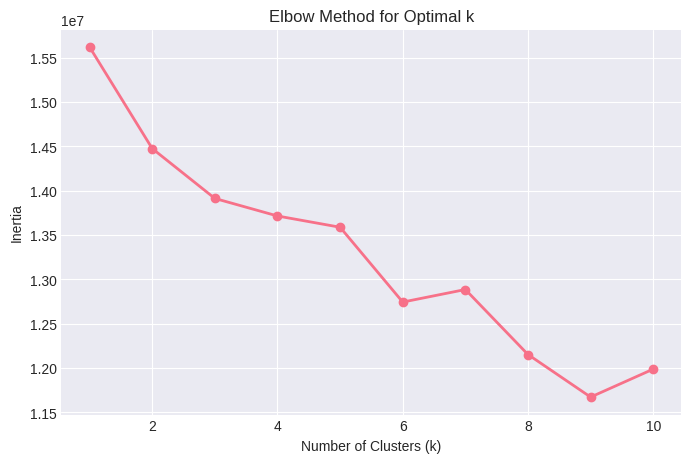

In [46]:
plt.figure(figsize=(8,5))
plt.plot(k_range, inertia_values, marker='o', linewidth=2)
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.grid(True)
plt.savefig("Elbow_Method.png")
plt.show()

####Train K-means with Optimal k

In [47]:
print("optimal k for k-means = ", optimal_k_elbow)

kmeans = KMeans(
    n_clusters=optimal_k_elbow,
    random_state=42,
    n_init=10,
    max_iter=300,
    verbose=0
)

kmeans.fit(X_train_scaled)

optimal k for k-means =  2


KMeans(n_clusters=np.int64(2), n_init=10, random_state=42)

In [48]:
train_clusters = kmeans.predict(X_train_scaled)
test_clusters = kmeans.predict(X_test_scaled)

In [49]:
print(f"Cluster centers shape: {kmeans.cluster_centers_.shape}")

Cluster centers shape: (2, 124)


####Model Evaluation

In [50]:
train_silhouette = silhouette_score(X_train_scaled, train_clusters)
test_silhouette = silhouette_score(X_test_scaled, test_clusters)

In [51]:
print(f"Silhouette Score (higher is better):")
print(f"Training: {train_silhouette:.4f}")
print(f"Test:     {test_silhouette:.4f}")

Silhouette Score (higher is better):
Training: 0.2344
Test:     -0.0293


In [54]:
train_db = davies_bouldin_score(X_train_scaled, train_clusters)
test_db = davies_bouldin_score(X_test_scaled, test_clusters)

print(f"Davies-Bouldin Index (lower is better):")
print(f"Training: {train_db:.4f}")
print(f"Test:     {test_db:.4f}")

Davies-Bouldin Index (lower is better):
Training: 2.7260
Test:     2.0249


The relatively low silhouette scores indicate overlapping traffic patterns, which is expected in real-world intrusion detection scenarios where malicious and benign traffic often share similar characteristics. Despite this, clustering metrics and label-based validation show that K-Means can still identify dominant attack behavior patterns without supervision.

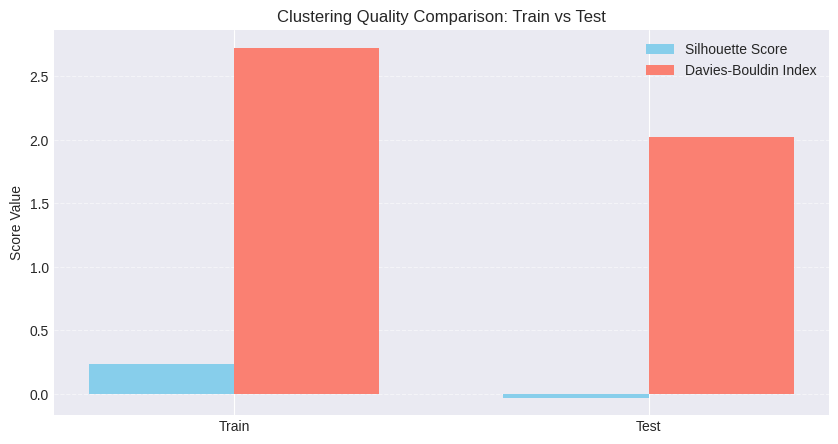

In [55]:
silhouette_scores = [train_silhouette, test_silhouette]
db_scores = [train_db, test_db]

labels = ["Train", "Test"]

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(10,5))
plt.bar(x - width/2, silhouette_scores, width, label="Silhouette Score", color="skyblue")

plt.bar(x + width/2, db_scores, width, label="Davies-Bouldin Index", color="salmon")

plt.xticks(x, labels)
plt.ylabel("Score Value")
plt.title("Clustering Quality Comparison: Train vs Test")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.5)

plt.savefig("Clustering_Quality_Comparison.png")
plt.show()


###Comparison

what if k becomes 3 -> **k = 3**

In [57]:
kmeans_k3 = KMeans(
    n_clusters=3,
    random_state=42,
    n_init=10,
    max_iter=300
)

kmeans_k3.fit(X_train_scaled)

KMeans(n_clusters=3, n_init=10, random_state=42)

In [58]:
train_clusters_k3 = kmeans_k3.predict(X_train_scaled)
test_clusters_k3 = kmeans_k3.predict(X_test_scaled)

print(f"Cluster centers shape (K=3): {kmeans_k3.cluster_centers_.shape}")

Cluster centers shape (K=3): (3, 124)


In [59]:
train_sil_k3 = silhouette_score(X_train_scaled, train_clusters_k3)
test_sil_k3 = silhouette_score(X_test_scaled, test_clusters_k3)

print("Silhouette Score (higher is better):")
print(f"K=3 → Training: {train_sil_k3:.4f}")
print(f"K=3 → Test:     {test_sil_k3:.4f}")

Silhouette Score (higher is better):
K=3 → Training: 0.1553
K=3 → Test:     -0.1178


In [60]:
train_db_k3 = davies_bouldin_score(X_train_scaled, train_clusters_k3)
test_db_k3 = davies_bouldin_score(X_test_scaled, test_clusters_k3)

print("\nDavies-Bouldin Index (lower is better):")
print(f"K=3 → Training: {train_db_k3:.4f}")
print(f"K=3 → Test:     {test_db_k3:.4f}")


Davies-Bouldin Index (lower is better):
K=3 → Training: 2.2364
K=3 → Test:     1.7607


In [62]:
from sklearn.decomposition import PCA

def create_pca_visualization(X_scaled, clusters, true_labels, title, filename):

    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    scatter1 = axes[0].scatter(X_pca[:, 0], X_pca[:, 1],
                              c=clusters, cmap='viridis',
                              alpha=0.6, s=10)
    axes[0].set_title(f'{title} - Clusters (K={len(np.unique(clusters))})')
    axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
    axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
    plt.colorbar(scatter1, ax=axes[0], label='Cluster')

    is_attack = (true_labels != "normal").astype(int) if isinstance(true_labels[0], str) else true_labels
    scatter2 = axes[1].scatter(X_pca[:, 0], X_pca[:, 1],
                              c=is_attack, cmap='coolwarm',
                              alpha=0.6, s=10)
    axes[1].set_title(f'{title} - True Labels (Red=Attack, Blue=Normal)')
    axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
    axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
    plt.colorbar(scatter2, ax=axes[1], label='Attack (1) / Normal (0)')

    plt.tight_layout()
    plt.savefig(f'{filename}.png', dpi=100, bbox_inches='tight')
    plt.show()

    print(f" PCA visualization saved as '{filename}.png'")
    print(f" Explained variance: PC1={pca.explained_variance_ratio_[0]:.2%}, "
          f"PC2={pca.explained_variance_ratio_[1]:.2%}")

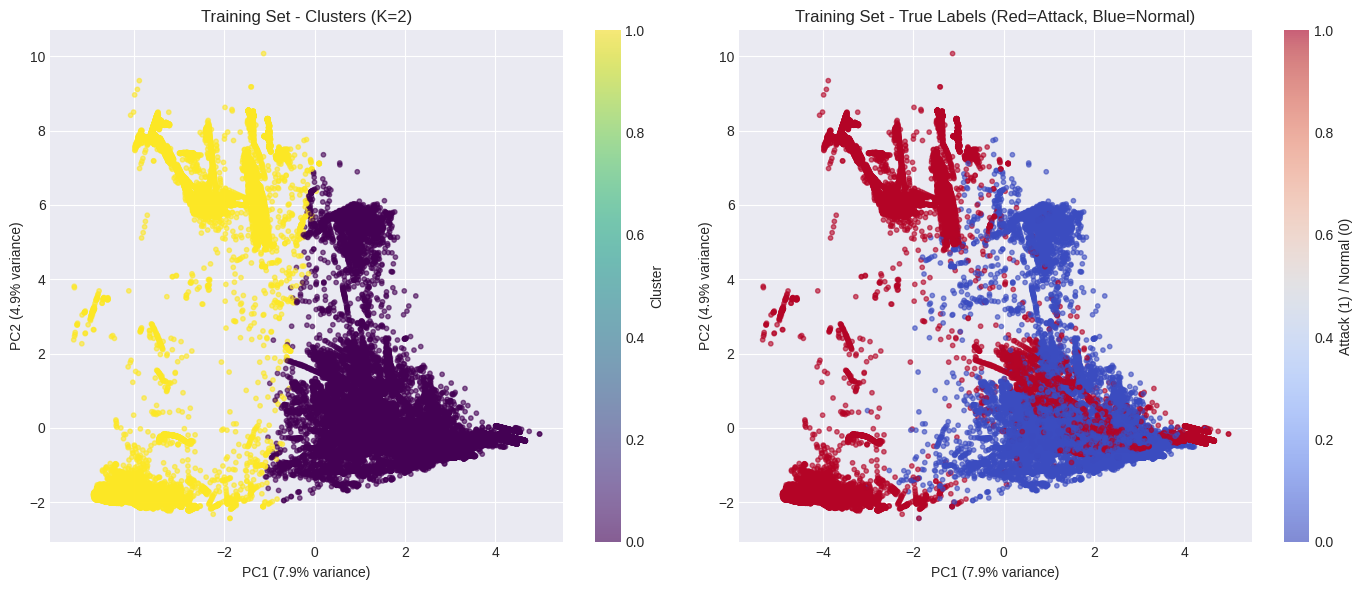

 PCA visualization saved as 'kmeans_training_pca.png'
 Explained variance: PC1=7.93%, PC2=4.91%


In [63]:
create_pca_visualization(X_train_scaled, train_clusters, y_train, "Training Set", "kmeans_training_pca")

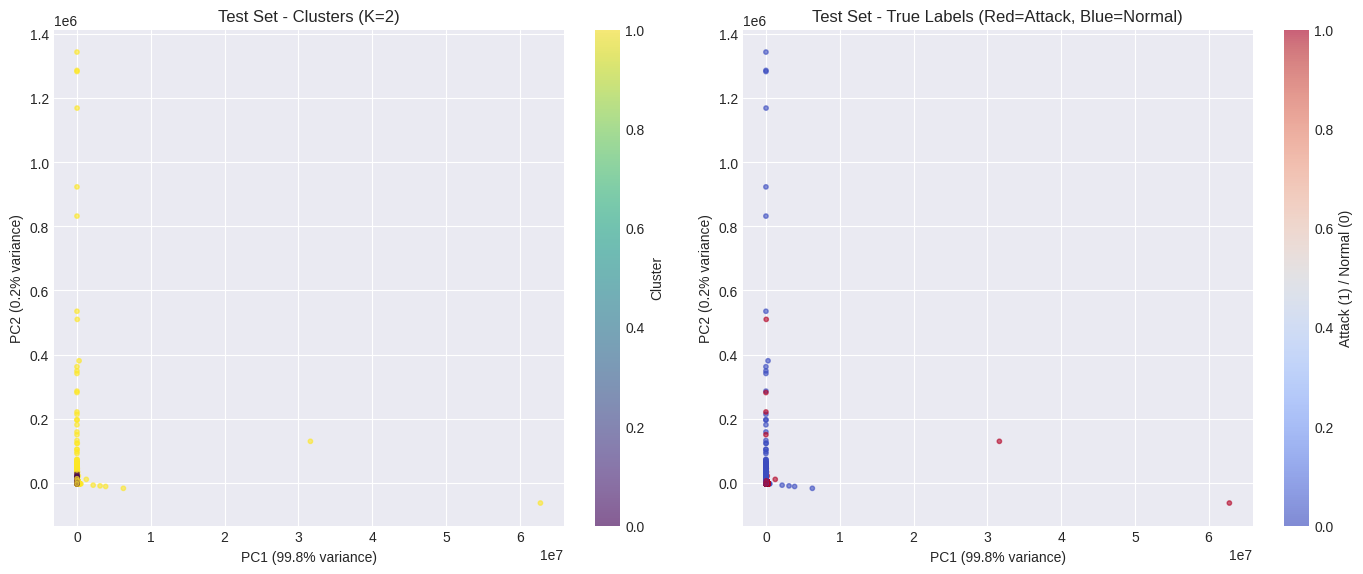

 PCA visualization saved as 'kmeans_test_pca.png'
 Explained variance: PC1=99.80%, PC2=0.20%


In [64]:
create_pca_visualization(X_test_scaled, test_clusters, y_test, "Test Set", "kmeans_test_pca")